In [1]:
import sys
sys.path.insert(1, '../../../utils')
from numpy import log, ndarray, array
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap

In [2]:
target = 'Total'
filename = "../data/raw/TrafficTwoMonth.csv"
file_tag = "traffic"
data: DataFrame = read_csv(filename, na_values="")

# Create datetime index using sequential 15-minute intervals
# Starting from a reference point (epoch-like approach)
data.index = date_range(start='2000-01-01', periods=len(data), freq='15min')
series: Series = data[target]
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
2000-01-01 00:00:00,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
2000-01-01 00:15:00,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2000-01-01 00:30:00,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
2000-01-01 00:45:00,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
2000-01-01 01:00:00,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


# Dimensionality

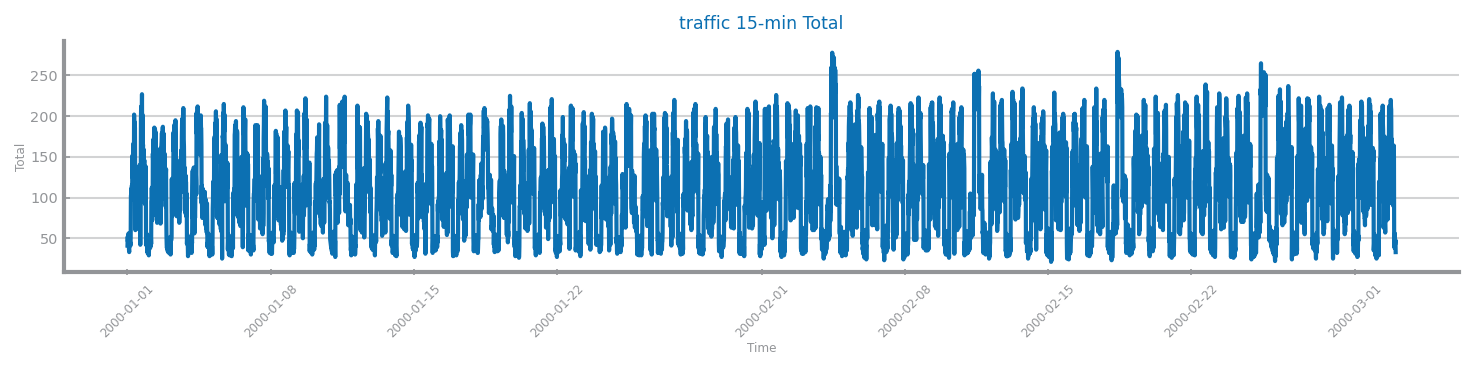

In [3]:
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel="Time",
    ylabel=target,
    title=f"{file_tag} 15-min {target}",
)
save_path = f"../charts/profiling/{file_tag}_dimensionality.png"
savefig(save_path, bbox_inches='tight')
show()

# Granularity

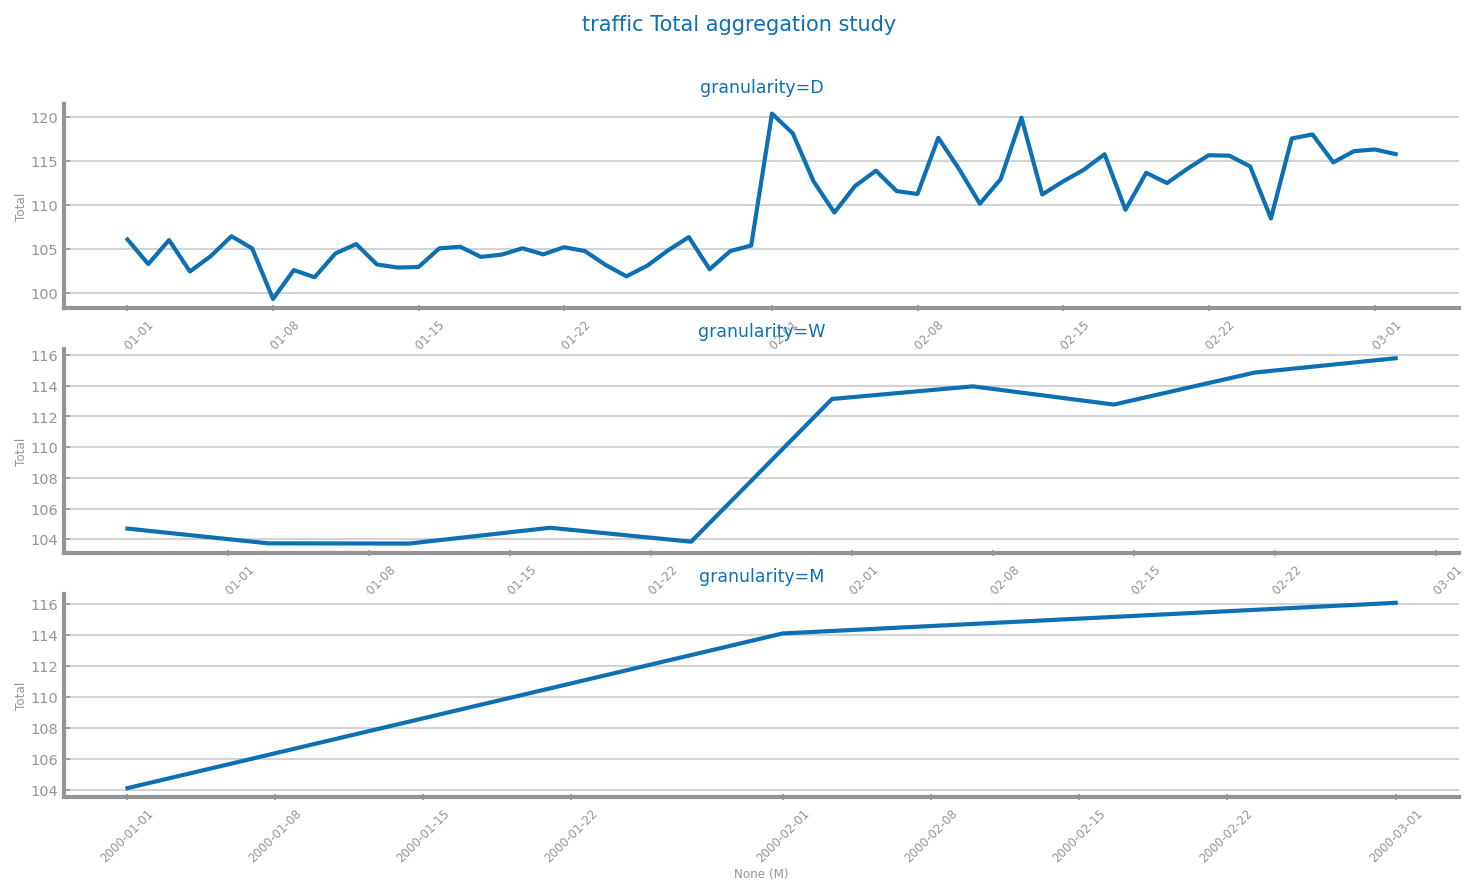

In [4]:
grans: list[str] = ["D", "W", "M"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i])
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )
save_path = f"../charts/profiling/{file_tag}_granularity.png"
savefig(save_path, bbox_inches='tight')
show()

# Distribution

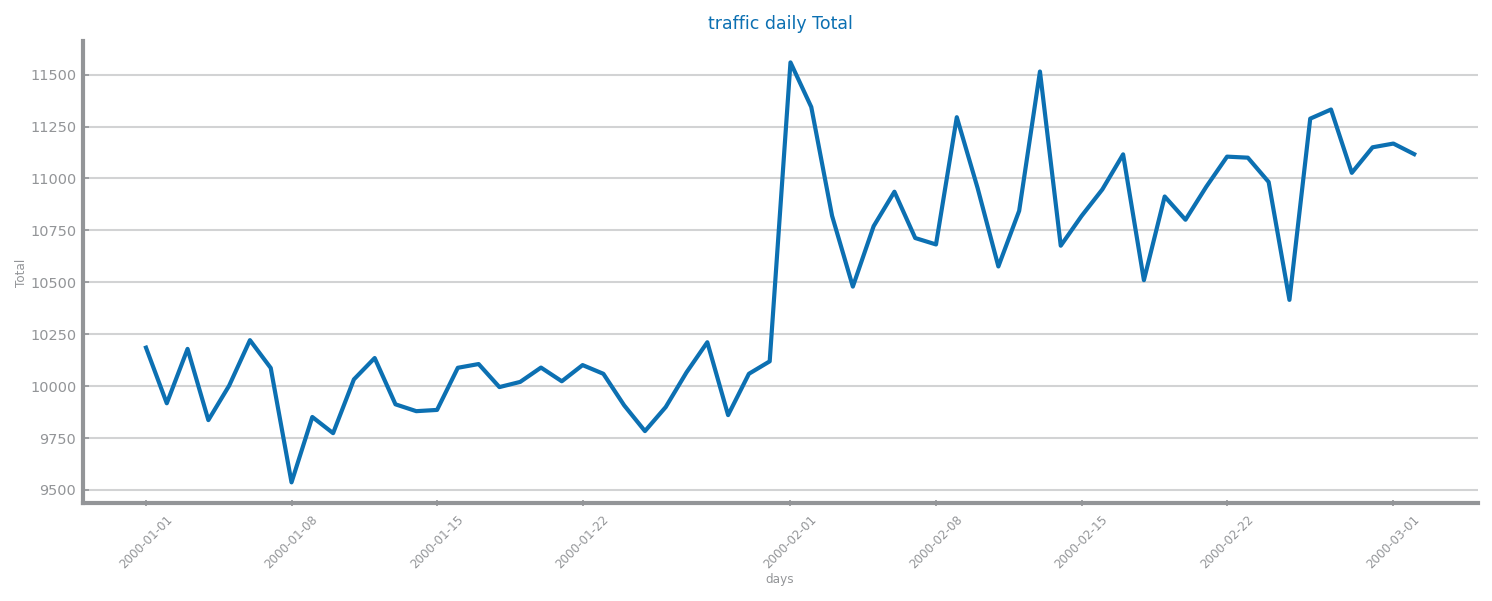

In [5]:
ss_weeks: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)

fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_weeks.index.to_list(),
    ss_weeks.to_list(),
    xlabel="days",
    ylabel=target,
    title=f"{file_tag} daily {target}",
)
save_path = f"../charts/profiling/{file_tag}_distribution_aggregation.png"
savefig(save_path, bbox_inches='tight')
show()

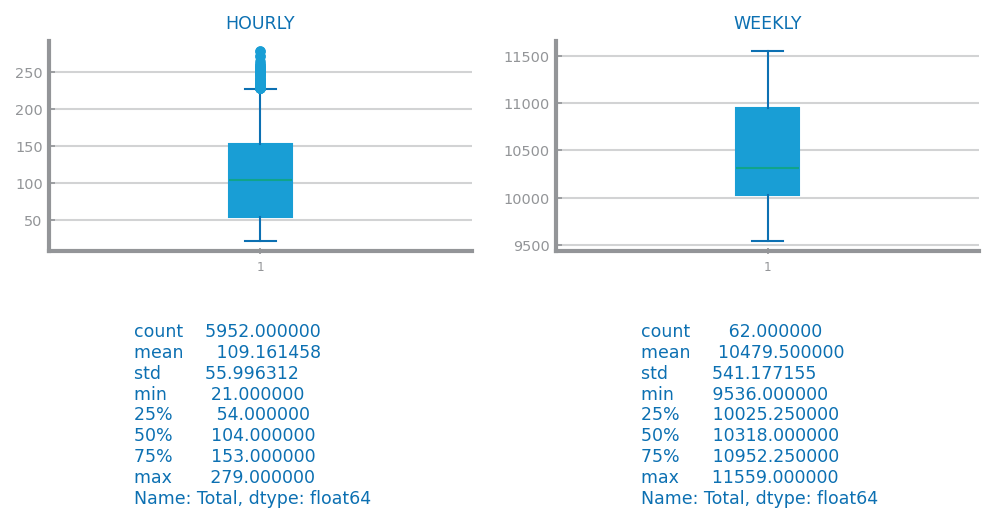

In [6]:
fig: Figure
axs: array
fig, axs = subplots(2, 2, figsize=(2 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="HOURLY")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="WEEKLY")
axs[0, 1].boxplot(ss_weeks)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_weeks.describe()), fontsize="small")

save_path = f"../charts/profiling/{file_tag}_distribution_5number_summary.png"
savefig(save_path, bbox_inches='tight')
show()

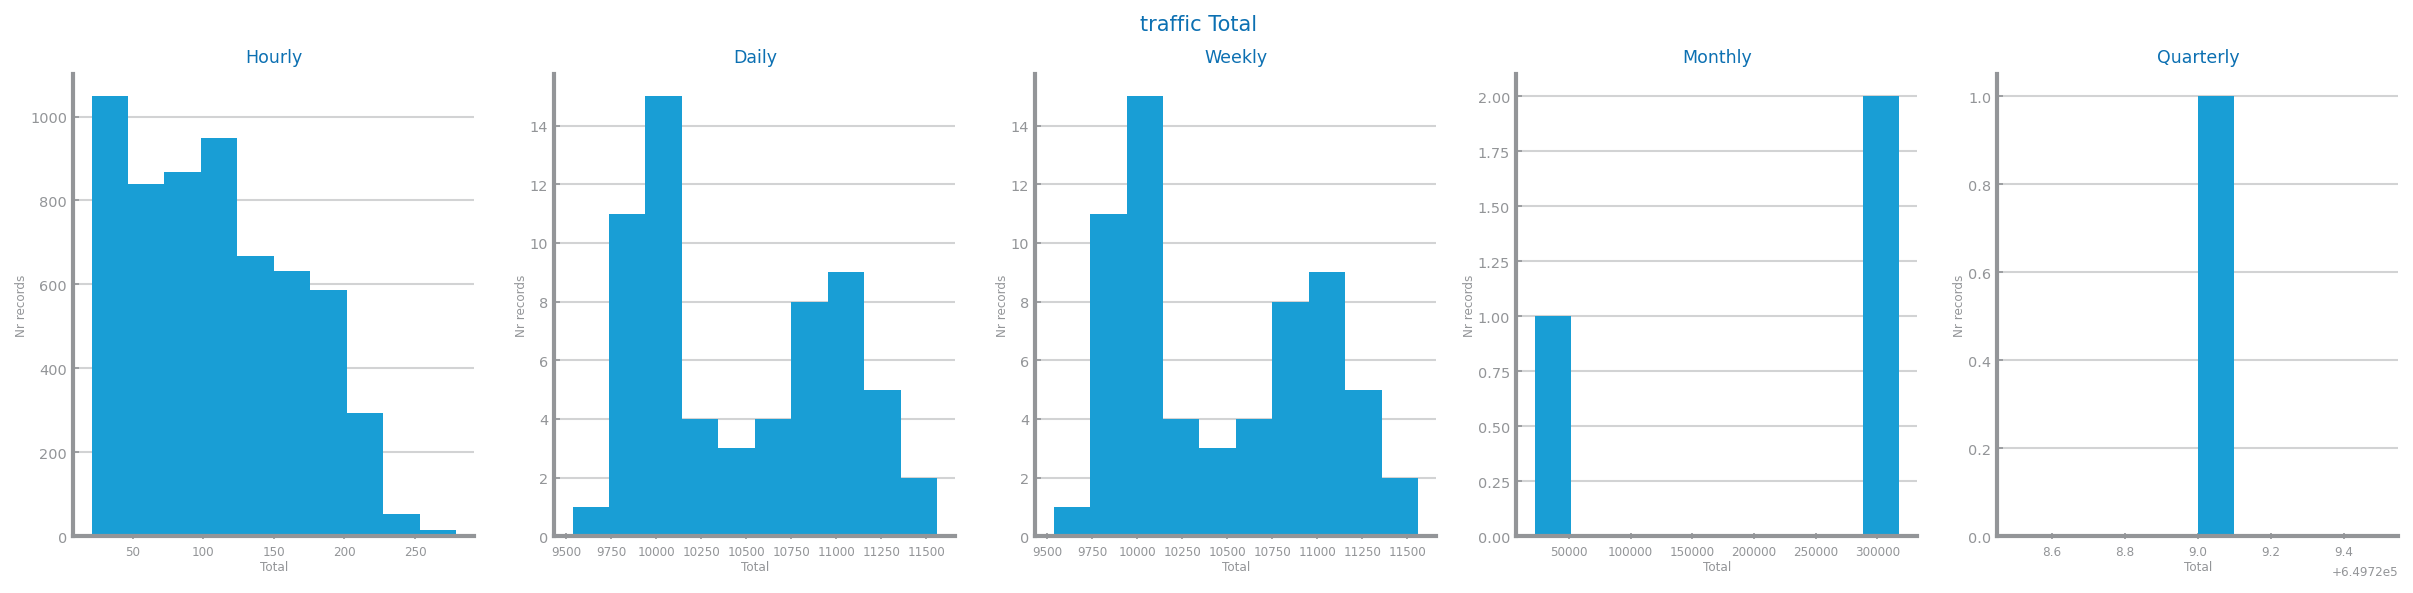

In [7]:
ss_days: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)
ss_months: Series = ts_aggregation_by(series, gran_level="M", agg_func=sum)
ss_quarters: Series = ts_aggregation_by(series, gran_level="Q", agg_func=sum)

grans: list[Series] = [series, ss_days, ss_weeks, ss_months, ss_quarters]
gran_names: list[str] = ["Hourly", "Daily", "Weekly", "Monthly", "Quarterly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
save_path = f"../charts/profiling/{file_tag}_distribution_variables_histogram.png"
savefig(save_path, bbox_inches='tight')
show()

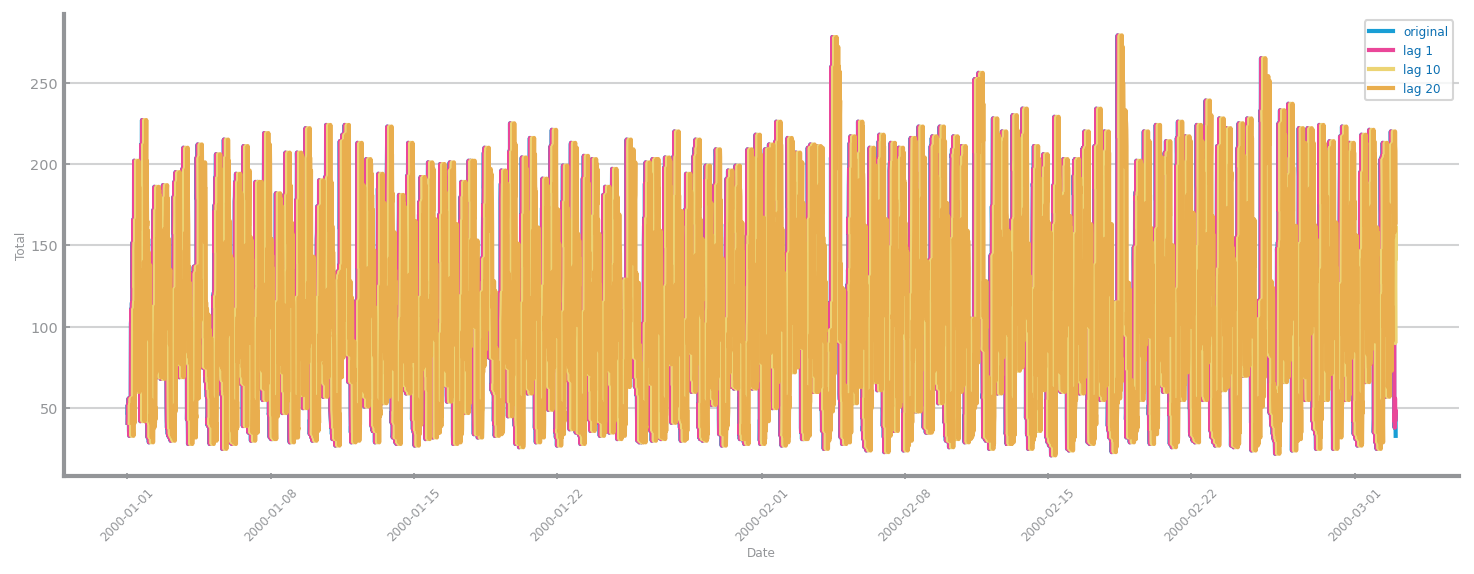

In [8]:
from dslabs_functions import plot_multiline_chart

def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series

figure(figsize=(3 * HEIGHT, 1 * HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel="Date", ylabel=target)
save_path = f"../charts/profiling/{file_tag}_dimensionality_autocorrelation_plot.png"
savefig(save_path, bbox_inches='tight')

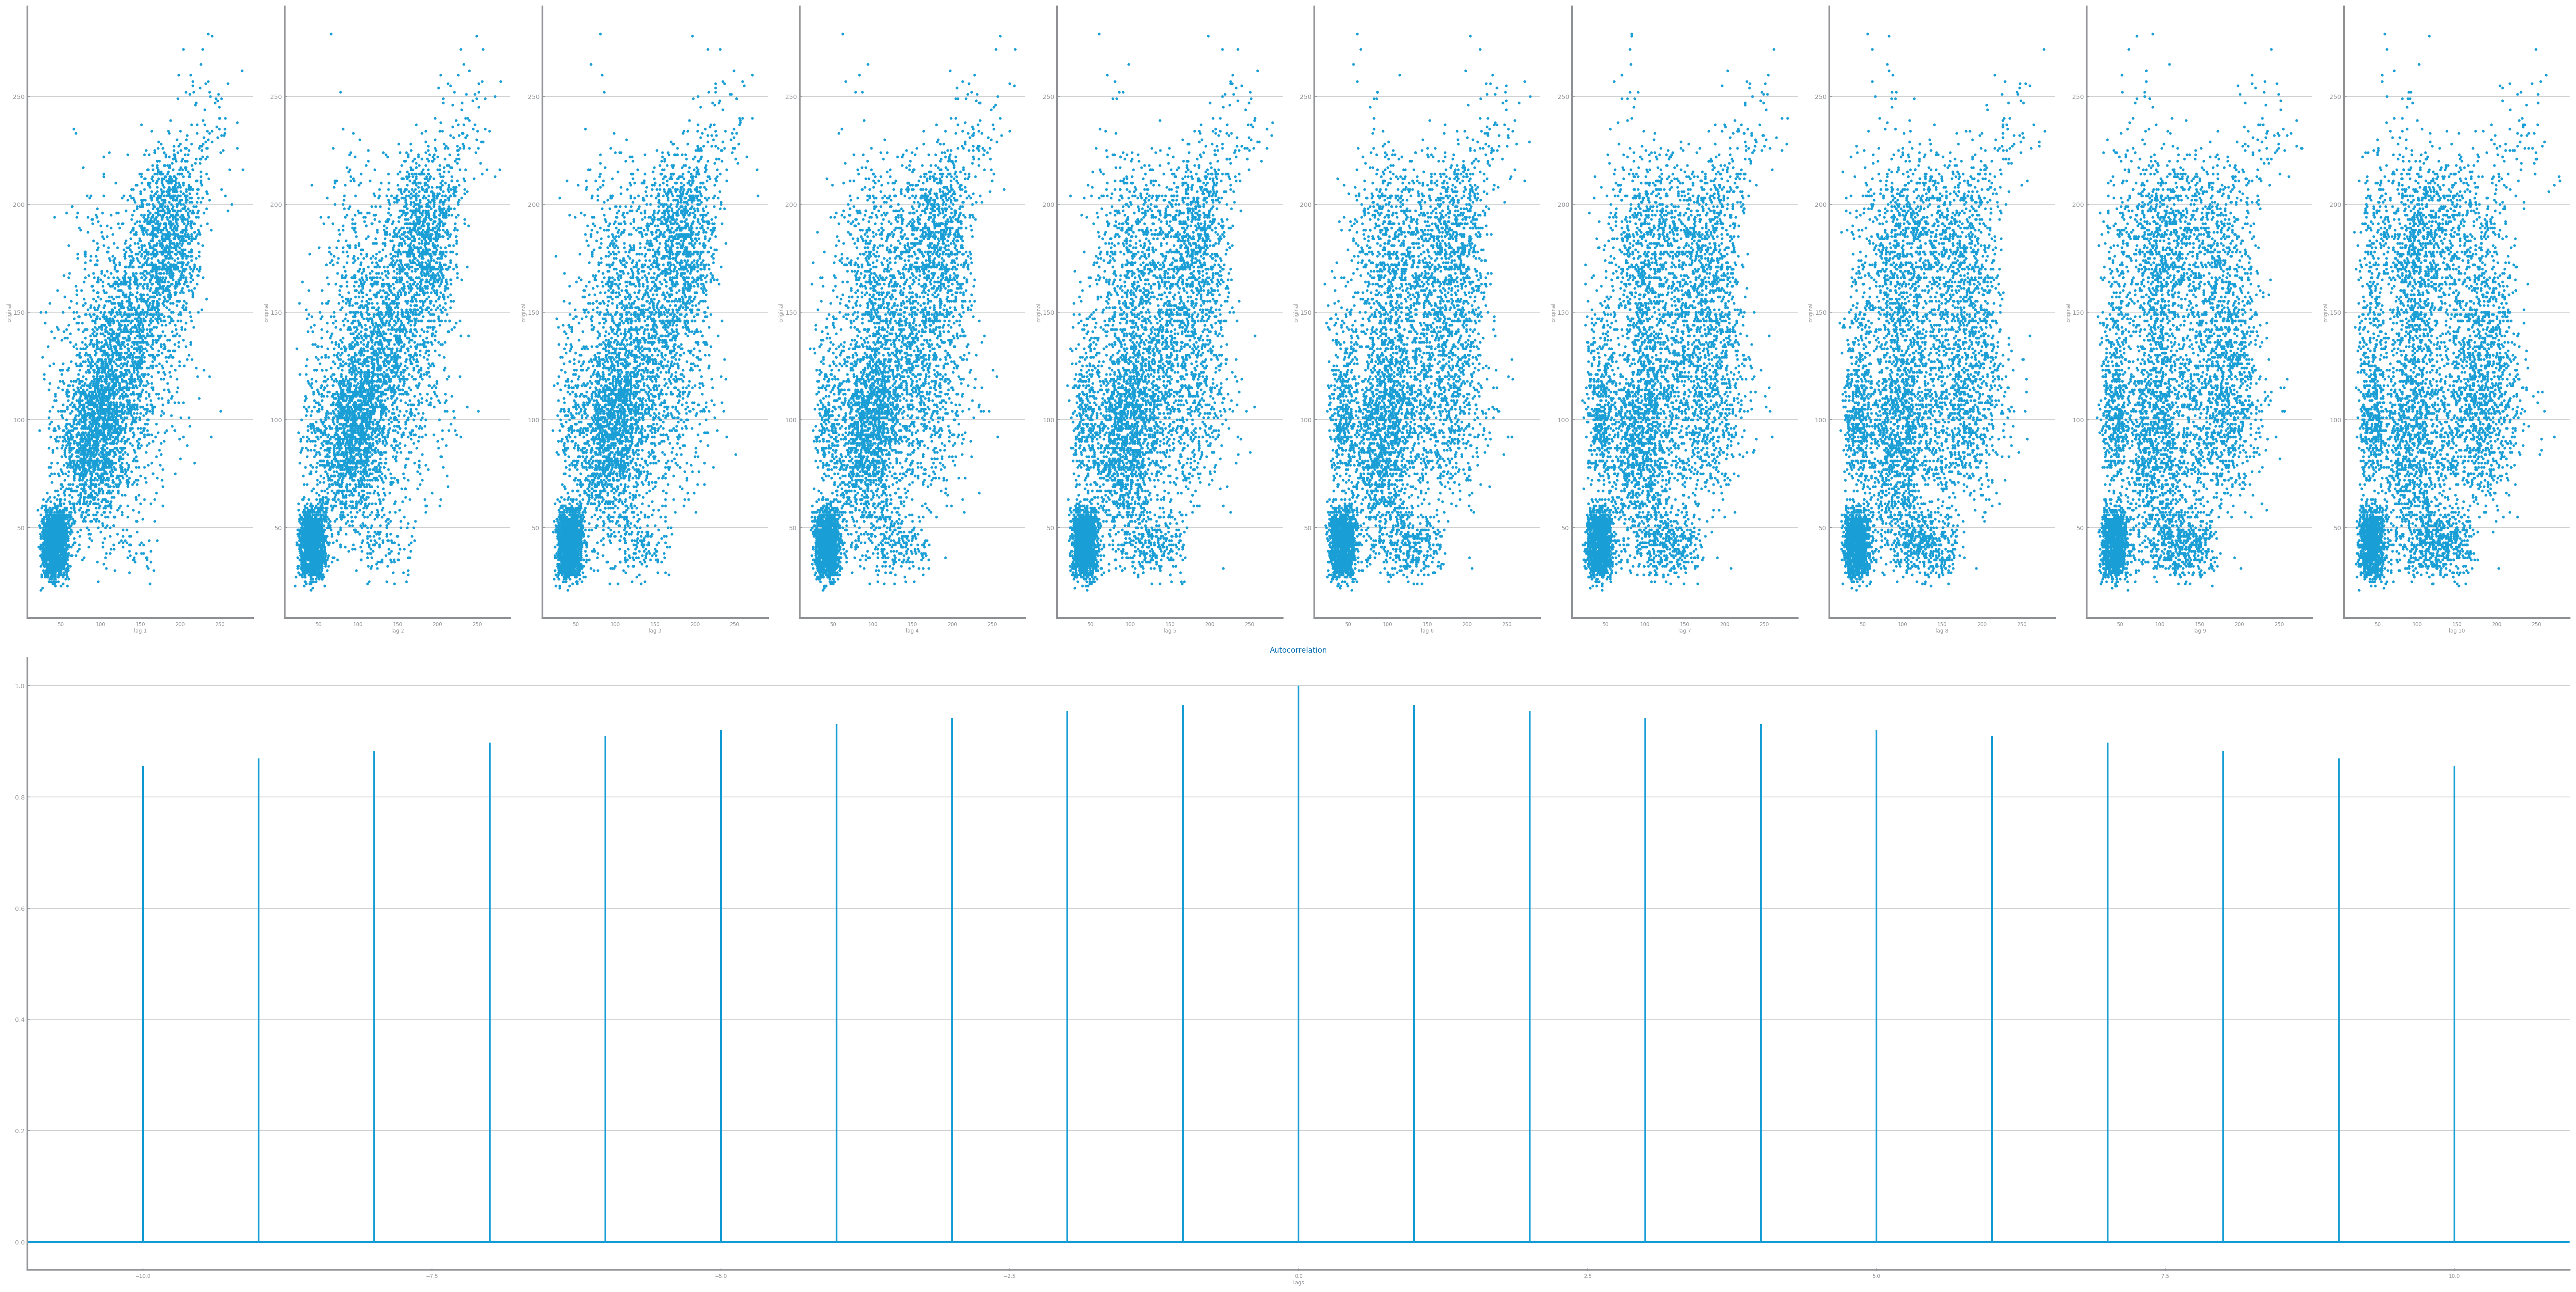

In [9]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(10 * HEIGHT, 5 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    save_path = f"../charts/profiling/{file_tag}_dimensionality_autocorrelation_study.png"
    savefig(save_path, bbox_inches='tight')
    return

autocorrelation_study(series, 10, 1)

# Seasonality and Stationarity

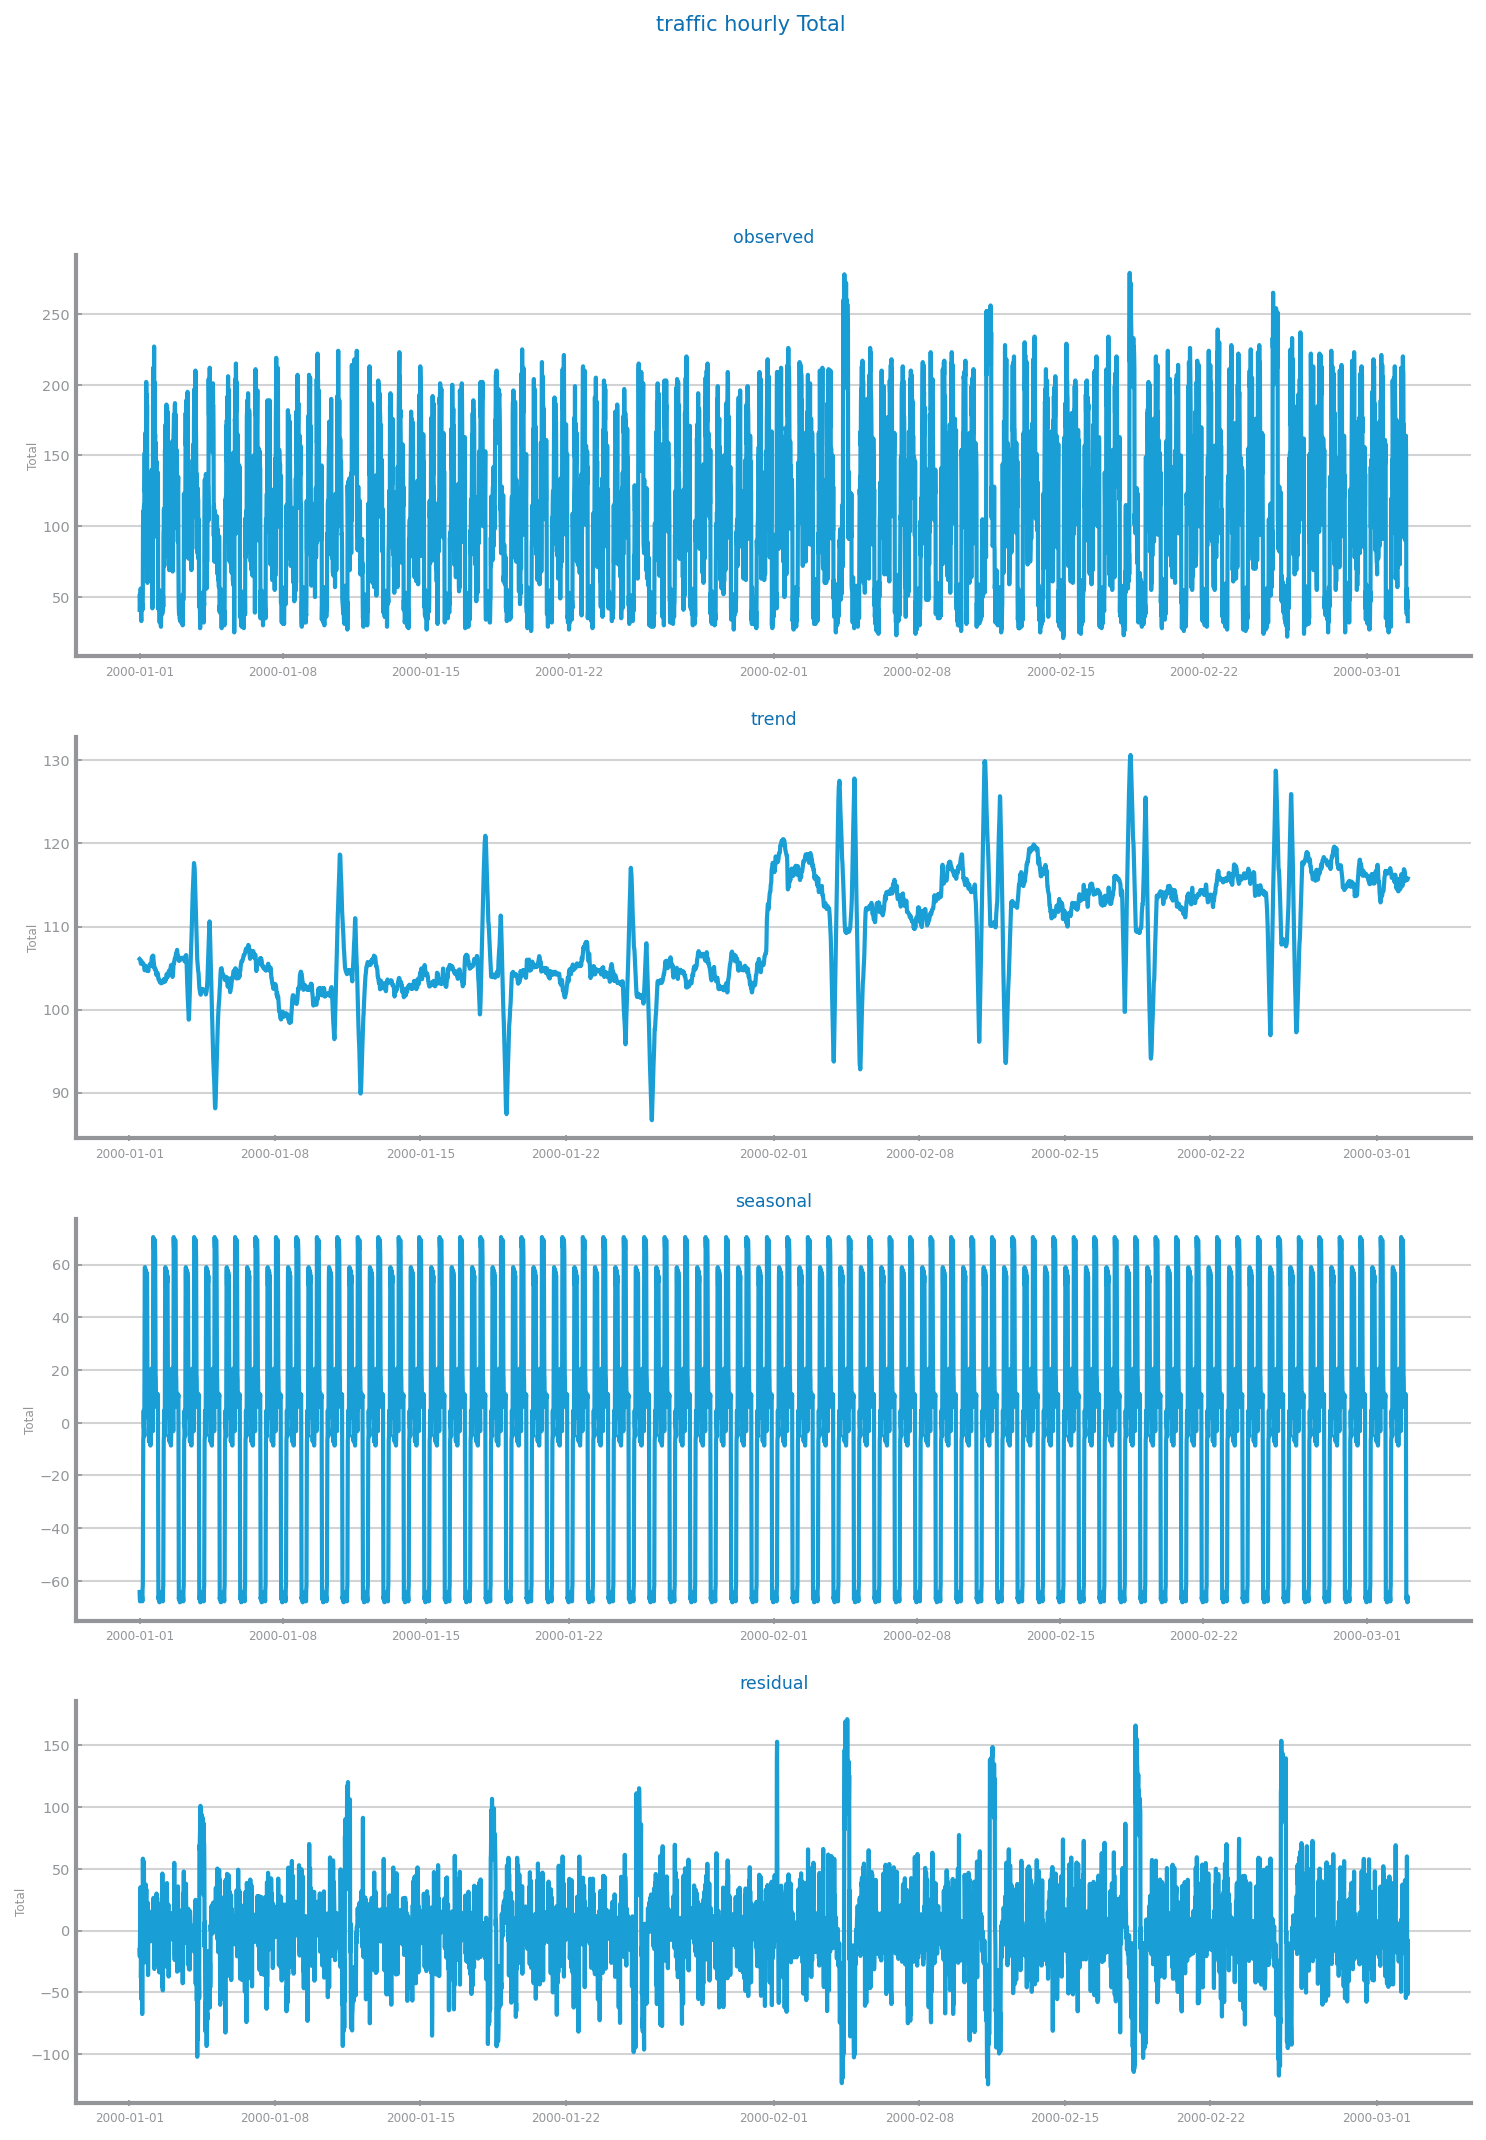

In [10]:
# For 15-minute intervals: 4 per hour * 24 hours = 96 periods per day
plot_components(
    series,
    title=f"{file_tag} hourly {target}",
    x_label=series.index.name,
    y_label=target,
    period=96,  # Daily seasonality (96 15-min intervals = 1 day)
)
save_path = f"../charts/profiling/{file_tag}_seasonality_components.png"
savefig(save_path, bbox_inches='tight')
show()

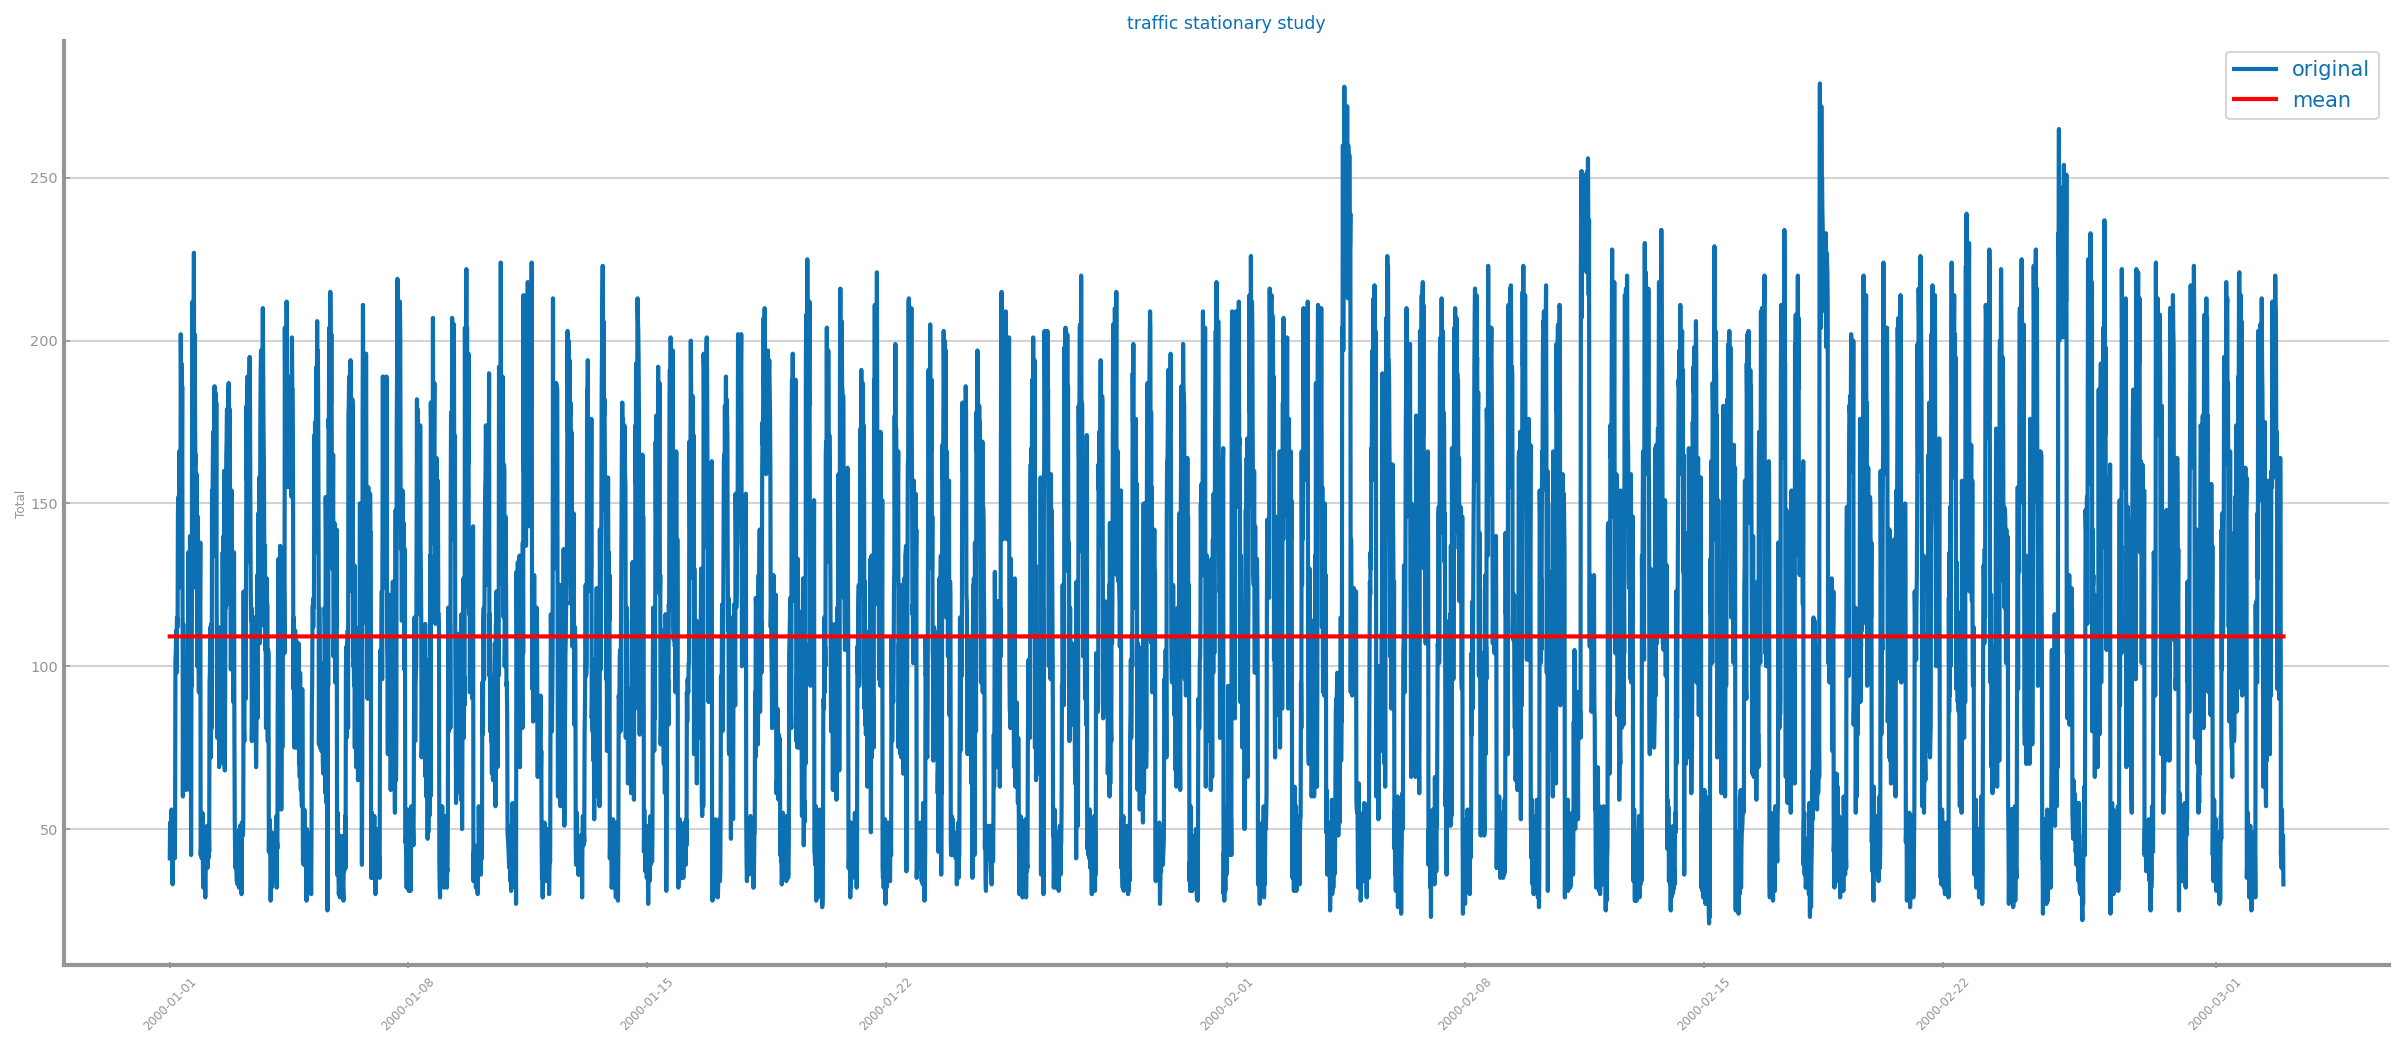

In [11]:
figure(figsize=(5 * HEIGHT, 2 * HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
save_path = f"../charts/profiling/{file_tag}_stationarity_study.png"
savefig(save_path, bbox_inches='tight')
show()

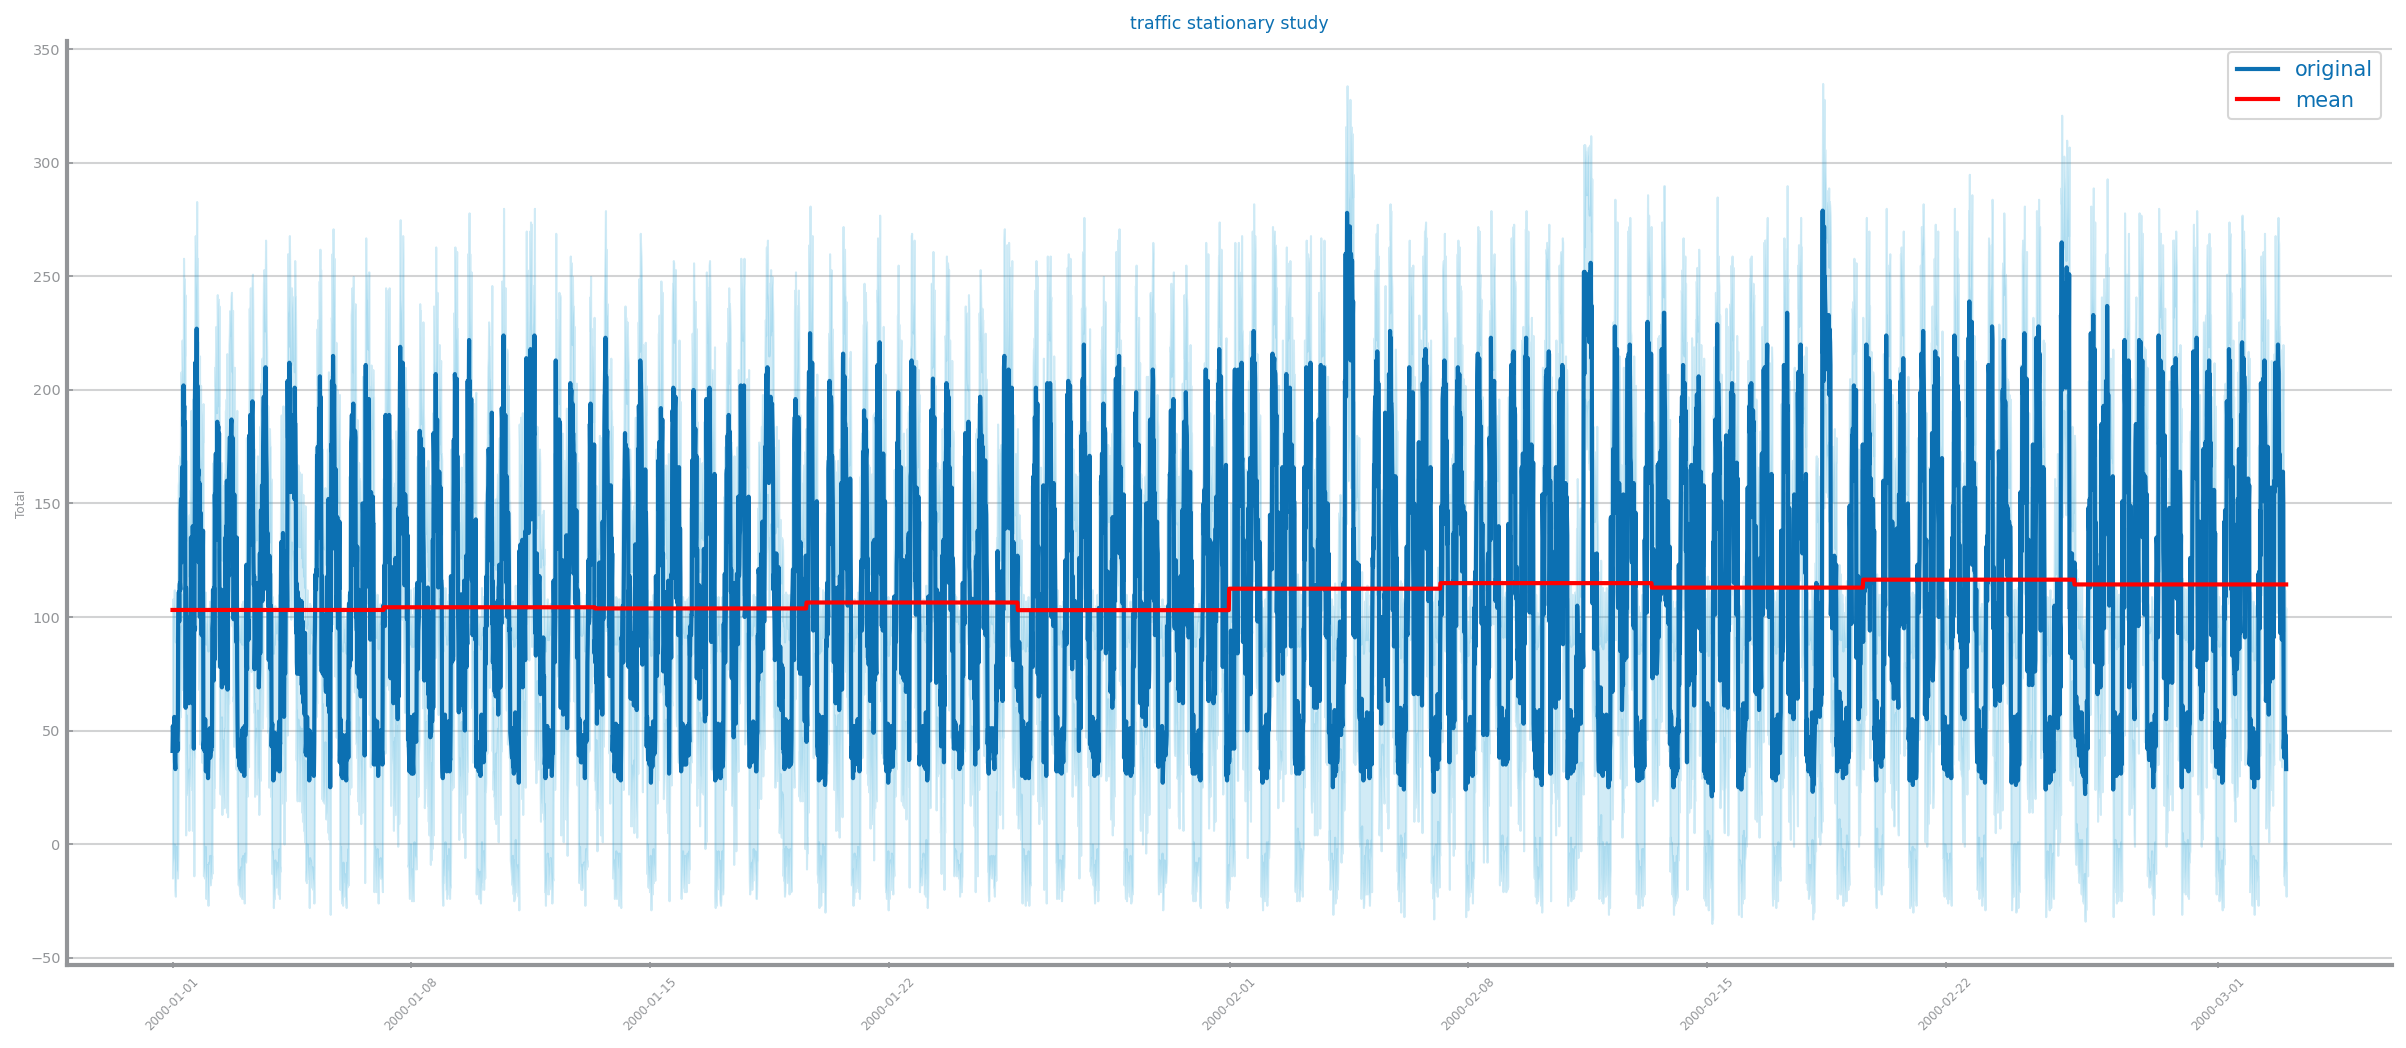

In [12]:
BINS = 10
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(5 * HEIGHT, 2 * HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
save_path = f"../charts/profiling/{file_tag}_stationarity_study_bins.png"
savefig(save_path, bbox_inches='tight')
show()

In [13]:
from statsmodels.tsa.stattools import adfuller

def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05

print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -14.441
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is stationary
